# 8. Daily Inference Pipeline (Production)

Generate predictions for the next trading day using the latest features from Hopsworks.

**Purpose**: Production inference only (predict future)
**Data Source**: Latest row from `qqq_combined_features` feature group
**Output**: Save prediction to `qqq_predictions` feature group

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from utils.hopsworks_helpers import get_feature_store
import joblib
import yaml
import warnings
warnings.filterwarnings('ignore')

# Load config
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("✓ Imports successful")

✓ Imports successful


## Load Models

In [2]:
# Load trained models from local storage
regressor_path = "../models/qqq_regressor.pkl"
classifier_path = "../models/qqq_classifier.pkl"

regressor = joblib.load(regressor_path)
classifier = joblib.load(classifier_path)

print("✓ Models loaded successfully")
print(f"  Regressor: {regressor_path}")
print(f"  Classifier: {classifier_path}")

# Get expected features from model
expected_features = regressor.get_booster().feature_names
print(f"\n✓ Model expects {len(expected_features)} features")

✓ Models loaded successfully
  Regressor: ../models/qqq_regressor.pkl
  Classifier: ../models/qqq_classifier.pkl

✓ Model expects 30 features


## Get Latest Features from Hopsworks

In [3]:
# Connect to Hopsworks
print("Connecting to Hopsworks...")
fs = get_feature_store()
print(f"✓ Connected to feature store: {fs.name}")

# Read directly from combined feature group (most reliable source)
print("\nLoading combined feature group...")
combined_fg = fs.get_feature_group('qqq_combined_features', version=1)
df = combined_fg.read()
print(f"✓ Feature group loaded: {len(df)} rows")

# Sort by date to get most recent data
df['date'] = pd.to_datetime(df['date'])
if hasattr(df['date'].dtype, 'tz') and df['date'].dtype.tz is not None:
    df['date'] = df['date'].dt.tz_localize(None)

df = df.sort_values('date').reset_index(drop=True)

# Get the most recent row
latest_row = df.tail(1).copy()
latest_date = latest_row['date'].iloc[0]

print(f"\n✓ Most recent data:")
print(f"  Date: {latest_date}")
print(f"  QQQ Close: ${latest_row['qqq_close'].iloc[0]:.2f}")

Connecting to Hopsworks...
2026-01-10 11:02:24,179 INFO: Initializing external client
2026-01-10 11:02:24,180 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-10 11:02:25,532 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272010
✓ Connected to feature store: scalable_lab1_featurestore

Loading combined feature group...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.68s) 
✓ Feature group loaded: 1131 rows

✓ Most recent data:
  Date: 2025-12-24 00:00:00
  QQQ Close: $623.93


## Data Freshness Validation

In [4]:
# Check data freshness (must be within 7 days for trading days)
days_old = (datetime.now() - latest_date).days

print(f"\n=== DATA FRESHNESS CHECK ===")
print(f"Latest data date: {latest_date.strftime('%Y-%m-%d')}")
print(f"Today's date: {datetime.now().strftime('%Y-%m-%d')}")
print(f"Data age: {days_old} days")

if days_old > 7:
    print(f"\n⚠️  WARNING: Data is {days_old} days old!")
    print(f"  This is too stale for reliable predictions.")
    print(f"  Recommendation: Run backfill notebooks to update data.")
    # Uncomment the next line to make this a hard error:
    # raise ValueError("Data too old for inference")
elif days_old > 3:
    print(f"\n⚠️  Note: Data is {days_old} days old (may include weekend).")
else:
    print(f"\n✓ Data freshness OK ({days_old} days old)")


=== DATA FRESHNESS CHECK ===
Latest data date: 2025-12-24
Today's date: 2026-01-10
Data age: 17 days

⚠️  WARNING: Data is 17 days old!
  This is too stale for reliable predictions.
  Recommendation: Run backfill notebooks to update data.


## Prepare Features for Inference

In [5]:
# Extract all features (exclude metadata and target columns)
feature_cols = [col for col in latest_row.columns 
                if col not in ['date', 'qqq_close', 'target_return', 'target_direction']]

X_latest = latest_row[feature_cols].copy()

# CRITICAL: Drop the same features that were dropped during training
# These sentiment aggregate features are redundant with positive/negative/neutral_mean
cols_to_drop = ['sentiment_mean', 'sentiment_std', 'article_count']
X_latest = X_latest.drop(columns=cols_to_drop, errors='ignore')

print(f"\n=== FEATURE PREPARATION ===")
print(f"Total features after dropping: {len(X_latest.columns)}")
print(f"Model expects: {len(expected_features)} features")

# Verify feature alignment
if list(X_latest.columns) != expected_features:
    print(f"\n⚠️  WARNING: Feature mismatch detected!")
    print(f"  Available: {list(X_latest.columns)}")
    print(f"  Expected: {expected_features}")
    
    # Try to reorder columns to match
    try:
        X_latest = X_latest[expected_features]
        print(f"\n✓ Features reordered to match model expectations")
    except KeyError as e:
        print(f"\n❌ ERROR: Missing features: {e}")
        raise
else:
    print(f"✓ Features match model expectations")

# Show sample feature values
print(f"\nSample feature values:")
for col in X_latest.columns[:5]:
    print(f"  {col:20s}: {X_latest[col].iloc[0]:.6f}")


=== FEATURE PREPARATION ===
Total features after dropping: 30
Model expects: 30 features
✓ Features match model expectations

Sample feature values:
  return_1d           : 0.309683
  return_2d           : 0.324604
  return_3d           : 0.680051
  return_5d           : 0.321505
  volatility_5d       : 0.237860


## Generate Predictions

In [6]:
# Make predictions
predicted_return = regressor.predict(X_latest)[0]
predicted_direction = classifier.predict(X_latest)[0]
predicted_proba = classifier.predict_proba(X_latest)[0, 1]  # Probability of UP

# Display predictions
print(f"\n{'='*60}")
print(f"PREDICTIONS FOR NEXT TRADING DAY")
print(f"{'='*60}")
print(f"Based on data from: {latest_date.strftime('%Y-%m-%d')}")
print(f"Prediction date: {datetime.now().strftime('%Y-%m-%d')}")
print(f"\nPredicted Return: {predicted_return:.4f} ({predicted_return*100:+.2f}%)")
print(f"\nPredicted Direction: {'📈 UP' if predicted_direction == 1 else '📉 DOWN'}")
print(f"  Probability of UP:   {predicted_proba:.4f} ({predicted_proba*100:.1f}%)")
print(f"  Probability of DOWN: {1-predicted_proba:.4f} ({(1-predicted_proba)*100:.1f}%)")
print(f"{'='*60}")


PREDICTIONS FOR NEXT TRADING DAY
Based on data from: 2025-12-24
Prediction date: 2026-01-10

Predicted Return: 0.0003 (+0.03%)

Predicted Direction: 📈 UP
  Probability of UP:   0.5210 (52.1%)
  Probability of DOWN: 0.4790 (47.9%)


## Feature Importance for This Prediction


Top 10 Features Driving This Prediction:
       feature  importance     value
   ma_ratio_50    0.065167  1.371921
  cpi_yoy_asof    0.061953  2.711969
 dgs10_chg_20d    0.060577  0.140000
  vix_ma_ratio    0.055601  0.912756
volatility_10d    0.055055  0.222979
     return_2d    0.047249  0.324604
  dgs10_chg_5d    0.047175 -0.010000
 volatility_5d    0.045891  0.237860
    vix_change    0.044261 -2.410000
     vix_close    0.043647 13.470000


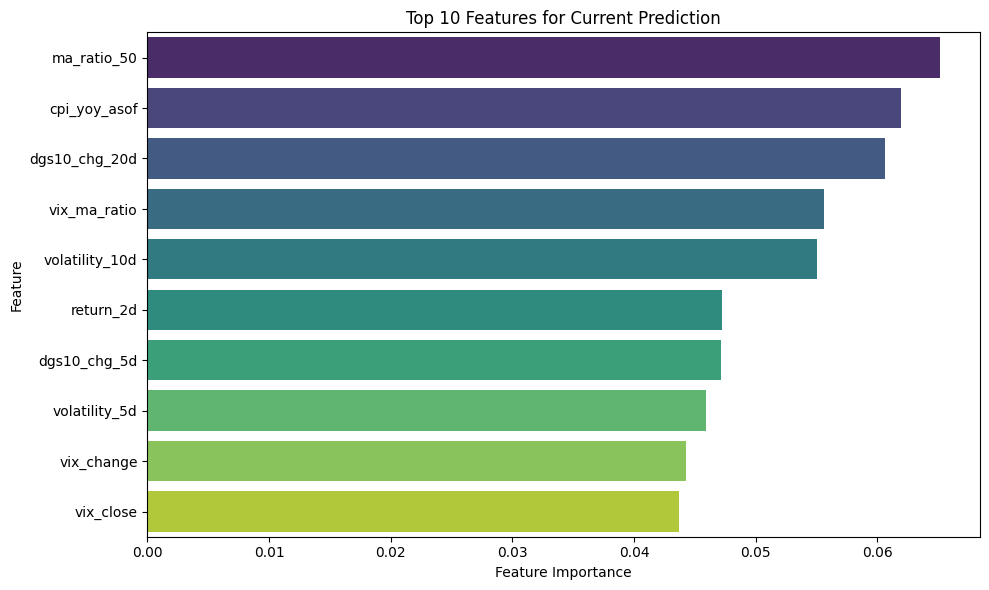

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': X_latest.columns,
    'importance': regressor.feature_importances_,
    'value': X_latest.values[0]
}).sort_values('importance', ascending=False)

# Display top 10
print("\nTop 10 Features Driving This Prediction:")
print(feature_importance.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature', palette='viridis')
plt.title('Top 10 Features for Current Prediction')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Save Prediction to Hopsworks

In [8]:
# Create prediction record
prediction_date = datetime.now()

prediction_record = pd.DataFrame([{
    'prediction_date': prediction_date,
    'feature_date': latest_date,
    'predicted_return': float(predicted_return),
    'predicted_direction': int(predicted_direction),
    'predicted_proba_up': float(predicted_proba),
    'model_version_regressor': 1,
    'model_version_classifier': 1,
    'qqq_close_at_prediction': float(latest_row['qqq_close'].iloc[0])
}])

# Add top 5 feature values for tracking
for idx, row in feature_importance.head(5).iterrows():
    prediction_record[f'feature_{row["feature"]}'] = row['value']

print("\nPrediction record created:")
print(prediction_record.T)


Prediction record created:
                                                   0
prediction_date           2026-01-10 11:02:31.716016
feature_date                     2025-12-24 00:00:00
predicted_return                            0.000252
predicted_direction                                1
predicted_proba_up                          0.521003
model_version_regressor                            1
model_version_classifier                           1
qqq_close_at_prediction                   623.929993
feature_ma_ratio_50                         1.371921
feature_cpi_yoy_asof                        2.711969
feature_dgs10_chg_20d                           0.14
feature_vix_ma_ratio                        0.912756
feature_volatility_10d                      0.222979


In [10]:
# Save to Hopsworks
try:
# Try to get existing feature group
    predictions_fg = fs.get_feature_group('qqq_predictions', version=1)
    if predictions_fg is None:
        raise ValueError("Feature group not found")
    print(f"✓ Using existing predictions feature group")
except:
    # Create if doesn't exist
    predictions_fg = fs.create_feature_group(
        name='qqq_predictions',
        version=1,
        description='Daily QQQ predictions with model outputs and key features',
        primary_key=['prediction_date'],
        event_time='prediction_date'
    )
    print(f"✓ Created new predictions feature group")

# Verify feature group is valid
if predictions_fg is None:
    raise ValueError("Failed to create or get feature group")

# Insert prediction
predictions_fg.insert(prediction_record, write_options={"wait_for_job": False})

print(f"\n✓ Prediction saved to Hopsworks")
print(f"  Prediction date: {prediction_date.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"  Feature date: {latest_date.strftime('%Y-%m-%d')}")


✓ Created new predictions feature group
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1272010/fs/1258611/fg/1908202


Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: qqq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272010/jobs/named/qqq_predictions_1_offline_fg_materialization/executions

✓ Prediction saved to Hopsworks
  Prediction date: 2026-01-10 11:02:31
  Feature date: 2025-12-24


## Summary

**Inference Complete!**

This notebook:
1. ✅ Loaded latest features from Hopsworks (`qqq_combined_features`)
2. ✅ Validated data freshness
3. ✅ Applied same feature transformations as training (dropped sentiment aggregates)
4. ✅ Generated predictions using trained models
5. ✅ Saved prediction to Hopsworks for dashboard visualization

**Next Steps:**
- View predictions in the Gradio dashboard
- Run this notebook daily for continuous predictions
- Use `9_backtest_evaluation.ipynb` to evaluate historical performance